# Food computer vision model

All these cells have been run in Google Colab

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
import os
HOME = os.getcwd()
print(HOME)

/Users/maxheilingbrunner/Documents/food-detection-classification


In [3]:
!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.10 torch-2.0.1 CPU
Setup complete ✅ (10 CPUs, 32.0 GB RAM, 1292.1/1858.2 GB disk)


In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

## Creation of a Custom model

loading Roboflow workspace...
loading Roboflow project...
{'predictions': [{'x': 828, 'y': 916, 'width': 1352, 'height': 754, 'confidence': 0.8223530054092407, 'class': 'Sushi', 'image_path': 'images/sushi.jpg', 'prediction_type': 'ObjectDetectionModel'}], 'image': {'width': '2560', 'height': '1707'}}


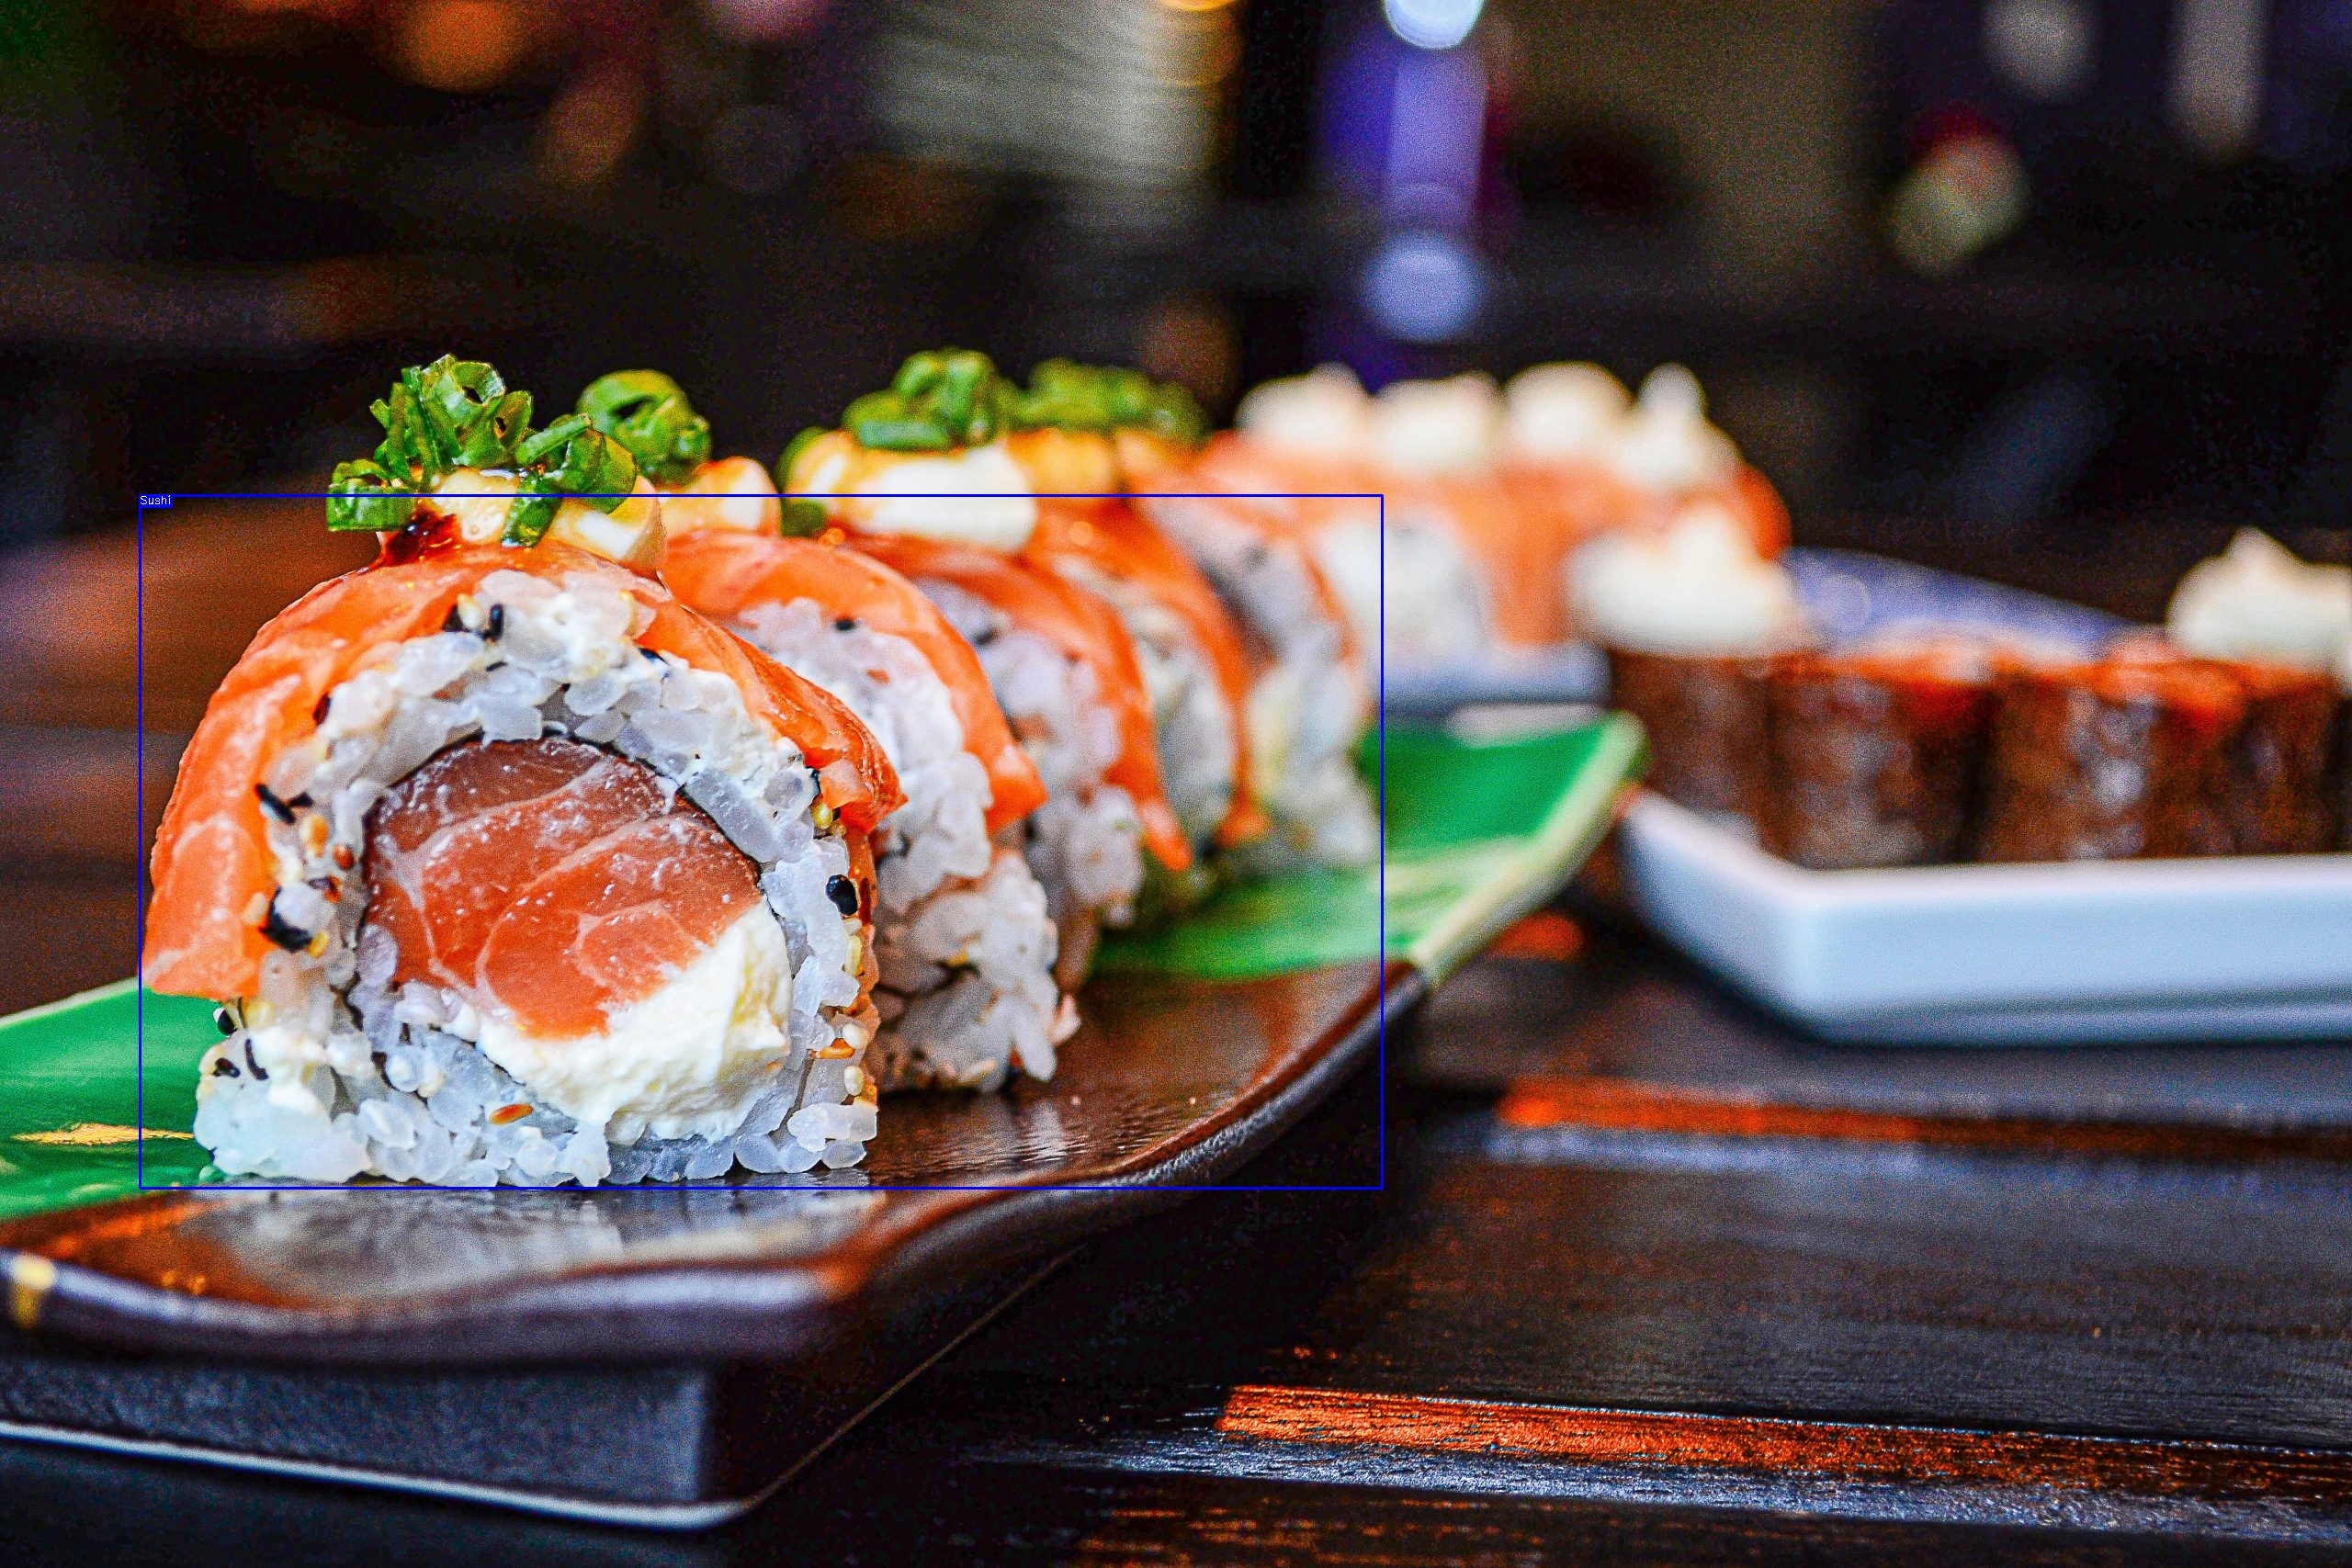

In [5]:
from roboflow import Roboflow

rf = Roboflow(api_key="Z55dUUrj0gRjWFCUAEAT")
project = rf.workspace().project("nutrition-fitbot")
model = project.version(1).model

image_name = "sushi"

# infer on a local image
data = model.predict(f"images/{image_name}.jpg", confidence=50, overlap=50).json()
print(data)

# visualize your prediction
model.predict(f"images/{image_name}.jpg", confidence=50, overlap=50).save(f"predictions/{image_name}_prediction.jpg")

# show image
Image(filename=f'predictions/{image_name}_prediction.jpg', height=600)

In [6]:
# Extract the class types from predictions
classes = list(set(prediction['class'] for prediction in data['predictions']))

# Print the list of class types
print(classes)

['Sushi']


## Custom Training

In [3]:
# Only once, otherwise comment to avoid redownloading
dataset = project.version(1).download('yolov8')

!yolo task=detect mode=train model=yolov8n.pt data=/Users/maxheilingbrunner/Documents/food-detection-classification/nutrition-fitbot-1/data.yaml epochs=1 imgsz=640 optimizer='Adam'

Ultralytics YOLOv8.0.20 🚀 Python-3.10.10 torch-2.0.1 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/Users/maxheilingbrunner/Documents/food-detection-classification/nutrition-fitbot-1/data.yaml, epochs=1, patience=50, batch=16, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=Fal

In [ ]:
!ls {HOME}/runs/segment/train/

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=600)

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train/results.png', width=600)

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=600)

In [ ]:
%cd {HOME}

!yolo task=segment mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

In [ ]:
%cd {HOME}
!yolo task=segment mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=true

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/segment/predict2/*.jpg')[:3]:
      display(Image(filename=image_path, height=600))
      print("\n")

In [ ]:
from sklearn.model_selection import ParameterGrid
from ultralytics import YOLO

# Define a grid of hyperparameters
param_grid = {'lr': [0.1, 0.01, 0.001],
              'batch_size': [16, 32, 64],
              'epochs': [5, 10, 20]}

# Iterate over each combination of hyperparameters
for params in ParameterGrid(param_grid):

    # Train a model with the current hyperparameters
    model = YOLO("yolov8n.pt")
    model.train(data="coco128.yaml", epochs=params['epochs'], batch_size=params['batch_size'], lr=params['lr'])

    # Evaluate the model and store the performance metrics
    metrics = model.val()

    # Keep track of the hyperparameters that result in the best performance
    if metrics['mAP'] > best_mAP:
        best_mAP = metrics['mAP']
        best_params = params


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)